In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim # 最佳化資料庫
from torchvision import datasets
from matplotlib import pyplot as plt

cifar10轉tensor和標準化

In [2]:
import os
data_path = os.getcwd() # 在datasets內建有CIFAR10

from torchvision import transforms

transformed_cifar10 = datasets.CIFAR10(
  data_path, train=True, download=True,
  transform=transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.4915, 0.4823, 0.4468),
  (0.2470, 0.2435, 0.2616))
]))
# val組
transformed_cifar10_val = datasets.CIFAR10(
  data_path, train=False, download=True,
  transform=transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.4915, 0.4823, 0.4468),
  (0.2470, 0.2435, 0.2616))
]))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/cifar-10-python.tar.gz to /content
Files already downloaded and verified


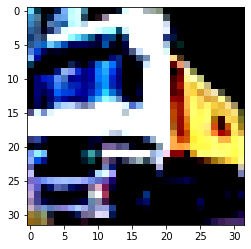

In [3]:
# tensor顯示圖片
img_t, _ = transformed_cifar10[1] # 必回傳一圖片+label
plt.imshow(img_t.permute(1, 2, 0)) # 從tensor(C,H,W)轉到numpy(H,W,C)

分辨飛機與鳥cifar2

In [4]:
# 只取鳥和飛機
label_map = {0: 0, 2: 1} # {飛機: 新的array的0位置, 鳥: 新的array的1位置} ex.為0就轉換為0 為2就轉換為1
class_names = ['airplane', 'bird'] 

# 若label為0和2 匯出其img和label label放到label_map轉換整數值
cifar2 = [(img, label_map[label]) 
      for img, label in transformed_cifar10
      if label in [0, 2]]
cifar2_val = [(img, label_map[label])
        for img, label in transformed_cifar10_val
        if label in [0, 2]]

開始訓練

ResBlock(重複區)

In [5]:
import torch.nn.functional as F

class ResBlock(nn.Module): # ResBlock
  def __init__(self, n_chans): 
    super(ResBlock, self).__init__() 
    # conv
    self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False) # 不需要bias 因為後面會normalize

    # norm
    self.batch_norm = nn.BatchNorm2d(num_features=n_chans) # BatchNorm2d用於2D 以minibatch為單位正規化(有bias+weight)
    torch.nn.init.constant_(self.batch_norm.weight, 0.5) # batch的weight初始為0.5(常數)
    torch.nn.init.zeros_(self.batch_norm.bias) # batch的bias初始為0

    # relu
    torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu') # kaiming方法去normal relu為和tahn一樣的激活神經網路
    
  def forward(self, x): # ResBlock執行順序 : conv + batch_norm + relu(神經網路)
    out = self.conv(x)
    out = self.batch_norm(out)
    out = torch.relu(out) 
    return out + x # out是訓練完的 x是未訓練的

NetResDeep model(一般區)

In [13]:
class NetResDeep(nn.Module):
  def __init__(self, n_chans1=32, n_blocks=10):
    super().__init__()
    self.n_chans1 = n_chans1 # 因為forward會用到 故需要用self定義
    self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
    self.resblocks = nn.Sequential(*(n_blocks * [ResBlock(n_chans=n_chans1)])) # n_blocks為做幾次跌代 nn.Sequential會自動調整大小並跌代
    self.fc1 = nn.Linear(8 * 8 * n_chans1, 32) 
    self.fc2 = nn.Linear(32, 2)

  def forward(self, x):
    out = F.max_pool2d(torch.relu(self.conv1(x)), 2) # conv 經過relu神經網路 再縮小成二分之一(16*16)
    out = self.resblocks(out) # 做n_block次的resblocks
    out = F.max_pool2d(out, 2) # 再縮小成二分之一(8*8)
    out = out.view(-1, 8 * 8 * self.n_chans1)
    out = torch.relu(self.fc1(out)) # 變扁平去訓練後 再進去一個relu
    out = self.fc2(out)
    return out

訓練一張圖片

In [12]:
img, _ = cifar2[0] 

In [15]:
model = NetResDeep()
model(img.unsqueeze(0)) # (B, C, H, W)

tensor([[-2.9127,  2.5342]], grad_fn=<AddmmBackward0>)

設定訓練參數

train_loader

In [16]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True) 

optimizer + loss_fn

In [17]:
optimizer = optim.SGD(model.parameters(), lr=1e-2) 
loss_fn = nn.CrossEntropyLoss() # 計算實際輸出(機率)與期望輸出(機率)的距離

training_loop

In [18]:
import datetime # 計算時間用

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
  for epoch in range(1, n_epochs + 1): 
    loss_train = 0.0 # 設定loss
    for imgs, labels in train_loader: # train_loader 和 CNN 為 ( B, C, H, W )
      outputs = model(imgs) # 訓練 得出機率
      loss = loss_fn(outputs, labels) # train_loader的labels為tensor 訓練機率和(0為飛機 1為鳥)比較

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      loss_train += loss.item() # loss_train為累加loss 有.item()就可以跳離grad

    if epoch == 1 or epoch % 10 == 0: 
      print('{} Epoch {}, Training loss {}'.format(
        datetime.datetime.now(), epoch,
        loss_train / len(train_loader))) # 除以loss次數

train loop

In [ ]:
training_loop(
  n_epochs = 100,
  optimizer = optimizer,
  model = model,
  loss_fn = loss_fn,
  train_loader = train_loader,
)